Import the Libraries

In [10]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tensorflow
from tensorflow.keras import models, layers

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
# Load Iris dataset
X, y = load_iris(return_X_y=True, as_frame=True)

In [3]:
# Concatenate features and target
df = pd.concat([X, y], axis=1)

In [5]:
#drop the duplicates
df = df.drop_duplicates()

In [6]:
# One-hot encode target variable
df = pd.concat([df, pd.get_dummies(df['target'], prefix='target')], axis=1)

Perform Correlation Analysis

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: >

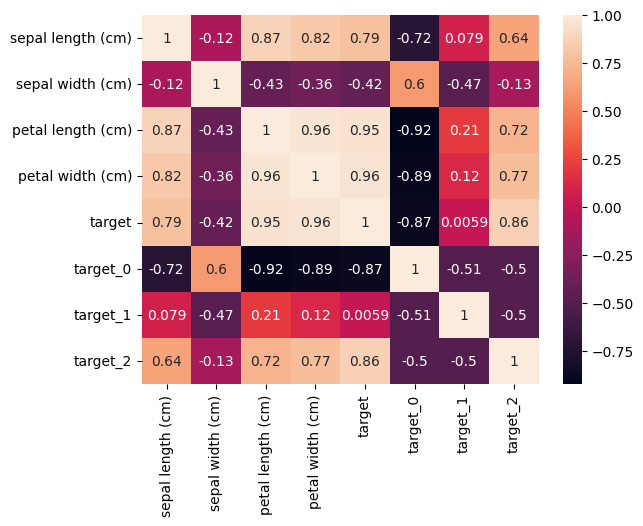

In [9]:
sns.heatmap(df.corr(), annot=True)

Here '0 : Setosa', '1: Versicolor', '2: Virginica'

As from the heatmap we can observe that petal length and petal width are highly correlated, we can use any one of them. Here petal length is suitable because it is slightly more correlated to the target.
Altough Sepal Width had a low correlation to target overall, because it had a predict effect for setosa, it can be kept for model prediction.

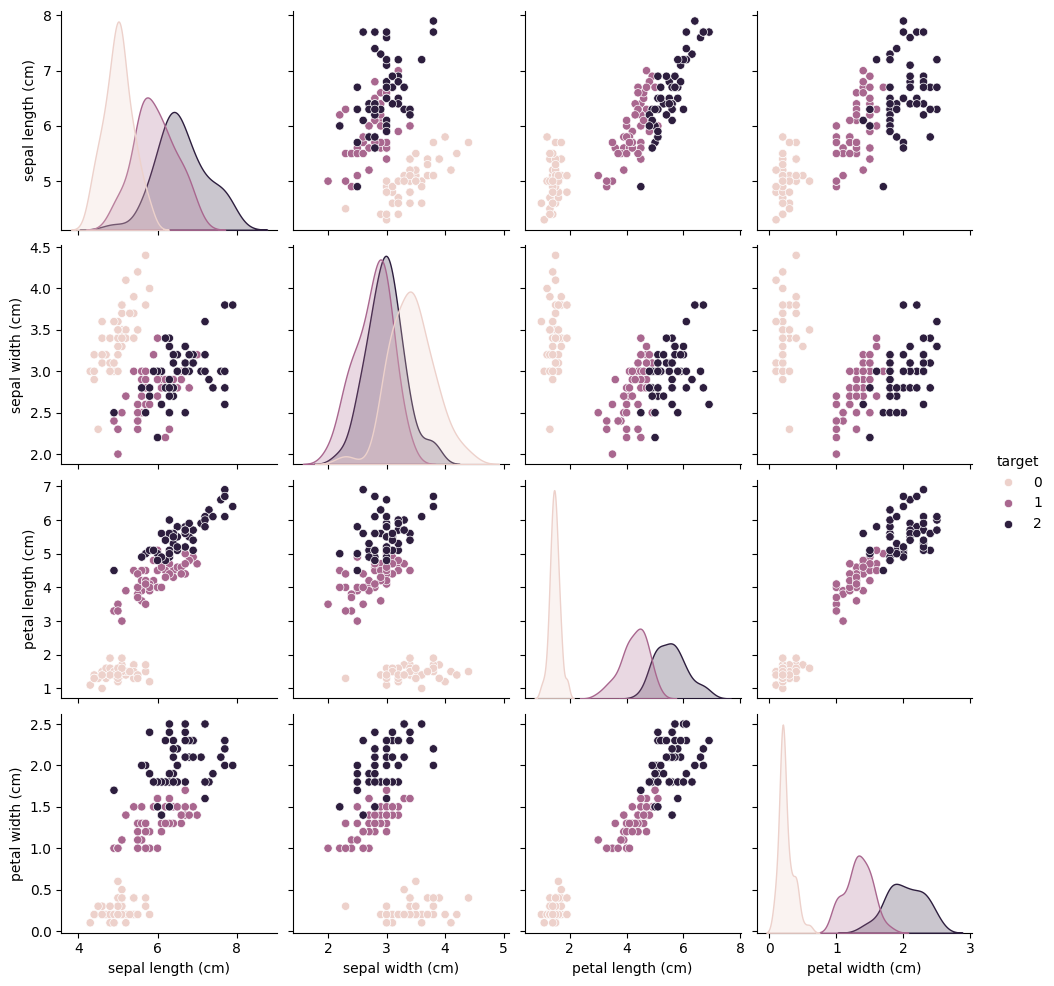

In [11]:
sns.pairplot(df.iloc[:,:-3], hue="target")

Feature Standardization

In [12]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.2, random_state=42)

In [16]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (119, 7)
y_train shape: (119, 3)


In [13]:
# One hot encoding
enc = OneHotEncoder(sparse_output = False)
y_train = enc.fit_transform(np.array(y_train).reshape(-1,1))
y_test = enc.transform(np.array(y_test).reshape(-1,1)) # Need to one-hot encode output for the neuralnetwork output layer

normalizer = tensorflow.keras.layers.Normalization(axis=-1)
normalizer.adapt(X_train)

NameError: name 'tensorflow' is not defined

In [14]:
#  One-hot encode output for the neural network output layer
# enc = OneHotEncoder(sparse_output=False)
# y_train_encoded = enc.fit_transform(np.array(y_train).reshape(-1, 1))
# y_test_encoded = enc.transform(np.array(y_test).reshape(-1, 1))

#  Normalize input features using Normalization layer
# normalizer = tensorflow.keras.layers.Normalization(axis=-1)
# normalizer.adapt(X_train)

Build the Neural Network

In [15]:
# Build the neural network model
network = models.Sequential()

# Add normalization layer
network.add(normalizer)

# Add dropout layer
network.add(layers.Dropout(0.2))

# Add the first dense layer with ReLU activation
network.add(layers.Dense(16, activation="relu", input_dim=X_train.shape[1]))

# Add dropout layer
network.add(layers.Dropout(0.2))

# Add the second dense layer with ReLU activation
network.add(layers.Dense(16, activation="relu"))

# Add the output layer with softmax activation for multi-class classification
network.add(layers.Dense(units=3, activation="softmax"))

# Compile the neural network
network.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

# Print the model summary
network.summary()

NameError: name 'models' is not defined

Train the Model

In [17]:
history = network.fit(X_train,
                    y_train,
                    epochs = 50,
                    batch_size = 32,
                    validation_split = 0.33
)

NameError: name 'network' is not defined

Evaluate the Loss Curve

NameError: name 'history' is not defined

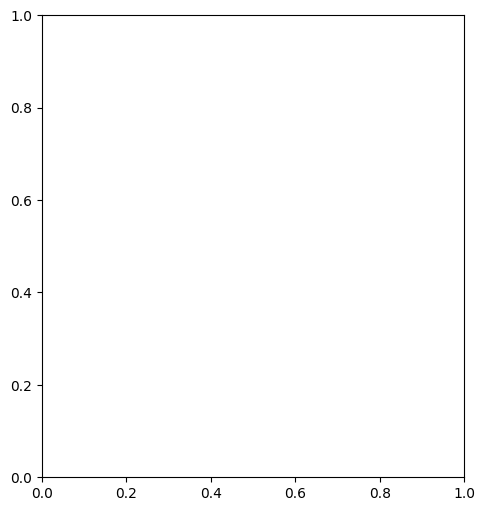

In [18]:
# Plotting the loss curves
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.show()

Evaluate ROC Curve

In [19]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

In [20]:
# Get the predicted probabilities for each class on the test set
y_pred_prob = network.predict(X_test)

# Binarize the true labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

# Calculate the ROC AUC for each class
roc_auc = roc_auc_score(y_test_bin, y_pred_prob, average='micro')

print(f'Micro-average ROC AUC: {roc_auc:.4f}')

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))

for i in range(3):  # Assuming you have 3 classes
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

NameError: name 'network' is not defined

In [21]:
#Using ravel() the resulting ROC curve will represent the aggregated performance across all classes. The AUC value is computed using the flattened true labels and predicted probabilities.
predictions = network.predict(X_test)

# Flatten both true labels and predicted probabilities
fpr, tpr, threshold = roc_curve(y_test.ravel(), predictions.ravel())

plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()
plt.show()

NameError: name 'network' is not defined

with the AUC of 1.000, the model works well in predicting the Iris species

Evaluate Confusion Matrix for each Species

In [23]:
from sklearn.metrics import confusion_matrix

In [25]:
# Convert one-hot encoded labels to class indices
true_labels_species = np.argmax(y_test, axis=1)
predicted_labels_species = np.argmax(predictions, axis=1)

# Create confusion matrix for each species
species = ['Setosa', 'Versicolor', 'Virginica']

for i, species_name in enumerate(species):
    true_labels_species_i = (true_labels_species == i).astype(int)  # Create binary labels for the specific species
    predicted_labels_species_i = (predicted_labels_species == i).astype(int)
    
# Compute and plot confusion matrix
    cm = confusion_matrix(true_labels_species_i, predicted_labels_species_i)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title(f'Confusion Matrix for {species_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

NameError: name 'predictions' is not defined

Evaluate Metrics

In [26]:
from sklearn.metrics import classification_report

# Convert one-hot encoded labels to class indices
true_labels_species = np.argmax(y_test, axis=1)
predicted_labels_species = np.argmax(predictions, axis=1)

# Print classification report for each species
species = ['Setosa', 'Versicolor', 'Virginica']

for i, species_name in enumerate(species):
    true_labels_species_i = (true_labels_species == i).astype(int)  # Create binary labels for the specific species
    predicted_labels_species_i = (predicted_labels_species == i).astype(int)
    
    # Print classification report
    report = classification_report(true_labels_species_i, predicted_labels_species_i, target_names=['Predicted Negative', 'Predicted Positive'])
    print(f'Classification Report for {species_name}:\n{report}\n')


NameError: name 'predictions' is not defined